      Akdital  Alliances  Aluminium Maroc  Attijariwafa  Auto Hall
0    0.015219  -0.018113         0.001484     -0.007353  -0.007899
1   -0.002840   0.007751        -0.000741      0.008642  -0.012146
2   -0.012502  -0.006307         0.000000     -0.001469   0.023770
3   -0.006250   0.009288         0.000000      0.000245   0.000534
4   -0.001613  -0.010736         0.000741      0.037990   0.023473
..        ...        ...              ...           ...        ...
118  0.013934   0.007397        -0.012977     -0.004348   0.000000
119 -0.003638   0.018816         0.013148      0.000764  -0.014350
120 -0.006085   0.009009        -0.007634      0.003600   0.000000
121 -0.009592  -0.003571         0.000000      0.000000  -0.022059
122  0.001442  -0.005376         0.000000      0.010870   0.007519

[123 rows x 5 columns]


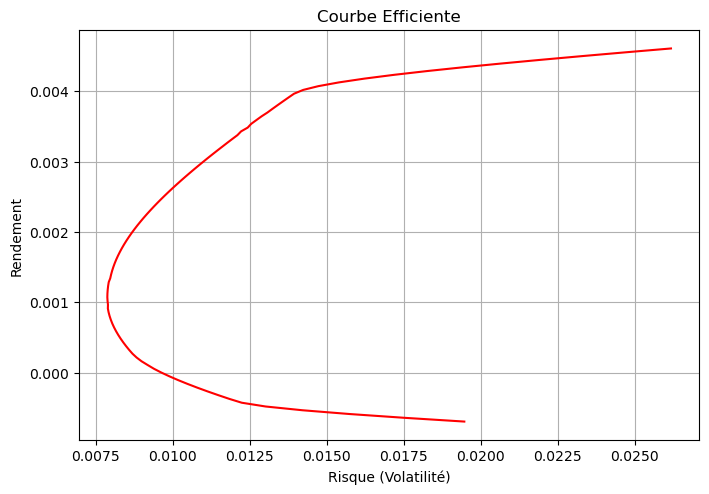

In [2]:
import tkinter as tk  # Importation de la bibliothèque Tkinter pour l'interface graphique
from tkinter import filedialog, messagebox  # Importation des dialogues de fichiers et messages d'erreur/succès
import pandas as pd  # Importation de pandas pour manipuler les fichiers Excel
import numpy as np  # Importation de NumPy pour les calculs mathématiques
import matplotlib.pyplot as plt  # Importation de Matplotlib pour tracer les graphiques
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg  # Intégration de Matplotlib avec Tkinter
from scipy.optimize import minimize  # Importation de la fonction de minimisation pour l'optimisation de portefeuille

# Fonction pour lire le fichier Excel
def load_excel_file():
    # Ouvre une boîte de dialogue pour sélectionner un fichier Excel
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx")])
    if file_path:  # Si un fichier a été sélectionné
        try:
            # Lecture du fichier Excel avec pandas
            df = pd.read_excel(file_path)
            print(df)  # Affiche les données dans la console pour vérification
            messagebox.showinfo("Succès", "Fichier chargé avec succès!")  # Message de succès
            calculate_efficient_frontier(df)  # Lance le calcul de la frontière efficiente
        except Exception as e:
            # En cas d'erreur lors de la lecture du fichier
            messagebox.showerror("Erreur", f"Impossible de lire le fichier : {e}")
    else:
        # Avertissement si aucun fichier n'est sélectionné
        messagebox.showwarning("Avertissement", "Aucun fichier sélectionné.")

# Fonction pour calculer la frontière efficiente
def calculate_efficient_frontier(df):
    # Vérifie si le fichier contient des valeurs manquantes
    if df.isnull().values.any():
        messagebox.showerror("Erreur", "Le fichier contient des valeurs manquantes.")
        return

    # Calcul du rendement moyen pour chaque actif et de la matrice de variance-covariance
    mean_returns = df.mean()
    cov_matrix = df.cov()

    # Création d'une liste de rendements cibles (100 points entre le rendement min et max)
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
    num_assets = len(mean_returns)  # Nombre d'actifs dans le portefeuille

    # Fonction pour calculer la volatilité (risque) d'un portefeuille
    def portfolio_volatility(weights, cov_matrix):
        return np.sqrt(weights.T @ cov_matrix @ weights)  # Volatilité = racine carrée de la variance

    # Fonction pour calculer le rendement d'un portefeuille
    def portfolio_return(weights, mean_returns):
        return weights @ mean_returns  # Produit matriciel des poids et des rendements

    # Listes pour stocker les risques et rendements des portefeuilles optimisés
    portfolio_risks = []
    portfolio_returns = []

    # Boucle sur chaque rendement cible
    for r_target in target_returns:
        # Définition des contraintes pour l'optimisation
        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Somme des poids doit être égale à 1
            {'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - r_target}  # Rendement cible
        )
        bounds = [(0, 1) for _ in range(num_assets)]  # Les poids doivent être compris entre 0 et 1
        initial_guess = num_assets * [1. / num_assets]  # Répartition initiale égale entre tous les actifs

        # Optimisation pour minimiser la volatilité (risque) sous les contraintes
        result = minimize(portfolio_volatility, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)

        # Si l'optimisation est un succès, stocker les résultats
        if result.success:
            portfolio_risks.append(result.fun)  # Ajouter la volatilité minimisée (risque)
            portfolio_returns.append(r_target)  # Ajouter le rendement cible
        else:
            print(f"Optimisation échouée pour le rendement cible : {r_target}")

    # Si aucun portefeuille n'est calculé, afficher une erreur
    if not portfolio_returns or not portfolio_risks:
        messagebox.showerror("Erreur", "Aucun résultat à afficher. Vérifiez les données.")
        return

    # Afficher la frontière efficiente
    plot_efficient_frontier(portfolio_returns, portfolio_risks)

# Fonction pour afficher la courbe efficiente
def plot_efficient_frontier(returns, risks):
    # Création d'une figure pour tracer la courbe
    plt.figure(figsize=(10, 6))
    plt.plot(risks, returns, label='Frontière Efficiente', color="red")  # Tracer la courbe
    plt.title('Courbe Efficiente')  # Titre du graphique
    plt.xlabel('Risque (Volatilité)')  # Étiquette de l'axe des x
    plt.ylabel('Rendement')  # Étiquette de l'axe des y
    plt.grid(True)  # Affichage de la grille

    # Suppression des anciens widgets dans le cadre (s'il y en a)
    for widget in frame.winfo_children():
        widget.destroy()
    
    # Intégration de la figure Matplotlib dans l'interface Tkinter
    figure = plt.gcf()  # Récupérer la figure courante
    canvas = FigureCanvasTkAgg(figure, root)  # Créer un canvas pour la figure
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)  # Afficher le canvas
    canvas.draw()  # Redessiner le graphique

# Création de l'interface Tkinter
root = tk.Tk()
root.title("Affichage de la Courbe Efficiente")  # Titre de la fenêtre
root.geometry("800x600")  # Taille de la fenêtre

# Création d'un cadre pour afficher le graphique
frame = tk.Frame(root)
frame.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# Bouton pour charger un fichier Excel
load_button = tk.Button(root, text="Charger un fichier Excel", command=load_excel_file)
load_button.pack(pady=20)  # Espacement autour du bouton

# Boucle principale de l'interface
root.mainloop()
